In [2]:
# =======================
# 라이브러리
# =======================
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False



# 경로 설정
DATA_DIR = Path("data/raw_data")
feat_path = DATA_DIR / "secom.data"
label_path = DATA_DIR / "secom_labels.data"

# 컬럼명 읽기 (secom.names 참고 가능)
n_features = 590  # 실제 590개 센서지만 1개는 timestamp용이거나 결측 가능
col_names = [f"Sensor_{i+1}" for i in range(590)]

# 데이터 로드
X = pd.read_csv(feat_path, sep=' ', header=None, names=col_names)
y = pd.read_csv(label_path, sep=' ', header=None, names=['Pass_Fail', 'Timestamp'])

print("데이터 크기:", X.shape)
print("라벨 크기:", y.shape)
X.head(3)


데이터 크기: (1567, 590)
라벨 크기: (1567, 2)


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_581,Sensor_582,Sensor_583,Sensor_584,Sensor_585,Sensor_586,Sensor_587,Sensor_588,Sensor_589,Sensor_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


In [3]:
# 결측치(NA) 확인
missing_ratio = X.isna().mean() * 100
print("결측 비율이 50% 이상인 센서 수:", (missing_ratio > 50).sum())

# 기본 통계량
X.describe().T.head(10)


결측 비율이 50% 이상인 센서 수: 28


,count,mean,std,min,25%,50%,75%,max
Sensor_1,1561.0,3014.452896,73.621787,2743.2400,2966.2600,3011.4900,3056.6500,3356.3500
Sensor_2,1560.0,2495.850231,80.407705,2158.7500,2452.2475,2499.4050,2538.8225,2846.4400
Sensor_3,1553.0,2200.547318,29.513152,2060.6600,2181.0444,2201.0667,2218.0555,2315.2667
Sensor_4,1553.0,1396.376627,441.691640,0.0000,1081.8758,1285.2144,1591.2235,3715.0417
Sensor_5,1553.0,4.197013,56.355540,0.6815,1.0177,1.3168,1.5257,1114.5366
Sensor_6,1553.0,100.000000,0.000000,100.0000,100.0000,100.0000,100.0000,100.0000
Sensor_7,1553.0,101.112908,6.237214,82.1311,97.9200,101.5122,104.5867,129.2522
Sensor_8,1558.0,0.121822,0.008961,0.0000,0.1211,0.1224,0.1238,0.1286
Sensor_9,1565.0,1.462862,0.073897,1.1910,1.4112,1.4616,1.5169,1.6564
Sensor_10,1565.0,-0.000841,0.015116,-0.0534,-0.0108,-0.0013,0.0084,0.0749


In [4]:
y['Pass_Fail'].value_counts()

Pass_Fail
-1    1463
 1     104
Name: count, dtype: int64

In [5]:
# 중앙값으로 결측치 대체
X = X.fillna(X.median())

# 대체 완료 확인
print("결측치 남은 컬럼 수:", X.isna().sum().gt(0).sum())


결측치 남은 컬럼 수: 0


In [6]:
data = X.copy()
data['Pass_Fail'] = y['Pass_Fail']

# 센서별 상관계수 계산
corr = data.corr()['Pass_Fail'].sort_values(ascending=False)
corr.head(10)


Pass_Fail     1.000000
Sensor_60     0.156008
Sensor_104    0.151230
Sensor_511    0.131662
Sensor_349    0.130807
Sensor_432    0.119936
Sensor_435    0.111312
Sensor_431    0.109115
Sensor_22     0.108333
Sensor_436    0.108260
Name: Pass_Fail, dtype: float64

Feature shape: (1567, 590)
Label shape: (1567, 2)
전체 결측 비율: 4.54%
총 변수 개수: 590
총 샘플 수: 1567
결측치 포함 비율(평균): 4.54%


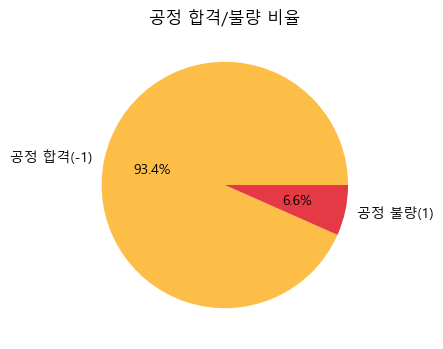

Pass_Fail
-1    93.363114
 1     6.636886
Name: proportion, dtype: float64


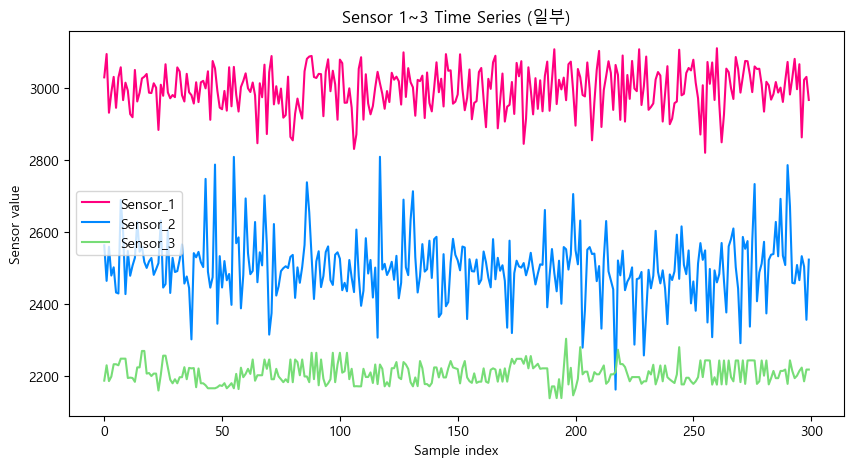

불량과 상관 높은 센서 TOP10:
 Sensor_60     0.155771
Sensor_104    0.151196
Sensor_511    0.131587
Sensor_349    0.130108
Sensor_432    0.120304
Sensor_435    0.111609
Sensor_431    0.109569
Sensor_436    0.108573
Sensor_22     0.107997
Sensor_29     0.106767
Name: Pass_Fail, dtype: float64


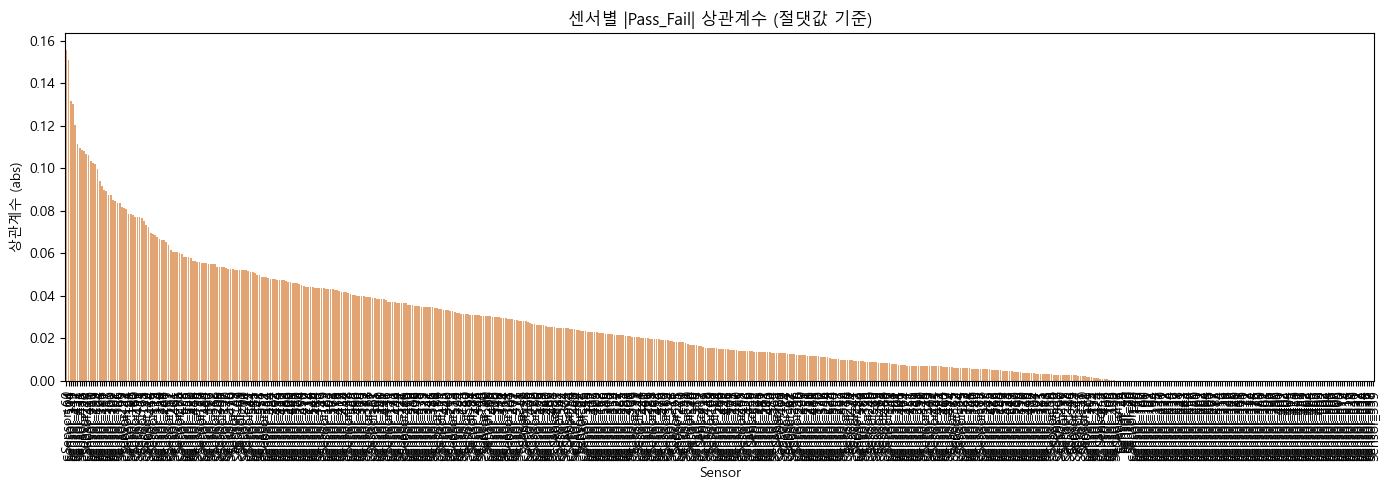

In [7]:
# =======================
# 1. 라이브러리 및 경로 설정
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 경로
DATA_DIR = Path("data/raw_data")
feat_path = DATA_DIR / "secom.data"
label_path = DATA_DIR / "secom_labels.data"

# =======================
# 2. 데이터 로드
# =======================
col_names = [f"Sensor_{i+1}" for i in range(590)]
X = pd.read_csv(feat_path, sep=' ', header=None, names=col_names)
y = pd.read_csv(label_path, sep=' ', header=None, names=['Pass_Fail', 'Timestamp'])

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

# =======================
# 3. 결측치 현황
# =======================
missing_ratio = X.isna().mean().mean() * 100
print(f"전체 결측 비율: {missing_ratio:.2f}%")

# Profile Table 스타일 요약
print("총 변수 개수:", X.shape[1])
print("총 샘플 수:", X.shape[0])
print("결측치 포함 비율(평균):", f"{missing_ratio:.2f}%")

# =======================
# 4. 결측치 대체 (평균값으로)
# =======================
X = X.fillna(X.mean())

# =======================
# 5. 라벨 분포 (Pie Chart)
# =======================
label_counts = y['Pass_Fail'].value_counts(normalize=True) * 100
plt.figure(figsize=(4,4))
plt.pie(label_counts, labels=['공정 합격(-1)', '공정 불량(1)'], 
        autopct='%1.1f%%', colors=['#FDBE47','#E63946'])
plt.title('공정 합격/불량 비율')
plt.show()

print(label_counts)

# =======================
# 6. 일부 센서 시각화 (Sensor 1~3)
# =======================
plt.figure(figsize=(10,5))
for i, color in zip(range(3), ['#FF007F', '#0088FF', '#77DD77']):
    plt.plot(X.iloc[:, i].values[:300], label=f'Sensor_{i+1}', color=color)
plt.legend()
plt.title('Sensor 1~3 Time Series (일부)')
plt.xlabel('Sample index')
plt.ylabel('Sensor value')
plt.show()

# =======================
# 7. 상관성 분석
# =======================
data = X.copy()
data['Pass_Fail'] = y['Pass_Fail']

# 각 센서와 불량 여부 간의 상관계수 계산
corr_series = data.corr()['Pass_Fail'].drop('Pass_Fail').abs().sort_values(ascending=False)

# 상위 10개 센서 출력
top10_sensors = corr_series.head(10)
print("불량과 상관 높은 센서 TOP10:\n", top10_sensors)

# 시각화
plt.figure(figsize=(14,5))
sns.barplot(x=corr_series.index, y=corr_series.values, color='#F4A261')
plt.xticks(rotation=90)
plt.title('센서별 |Pass_Fail| 상관계수 (절댓값 기준)')
plt.ylabel('상관계수 (abs)')
plt.xlabel('Sensor')
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
print("XGBoost import OK")


XGBoost import OK


SMOTE 후 라벨 분포:
Pass_Fail
0    1023
1    1023
Name: count, dtype: int64
===== Classification Report =====
              precision    recall  f1-score   support

       정상(0)      0.943     0.936     0.940       440
       불량(1)      0.176     0.194     0.185        31

    accuracy                          0.887       471
   macro avg      0.560     0.565     0.562       471
weighted avg      0.892     0.887     0.890       471



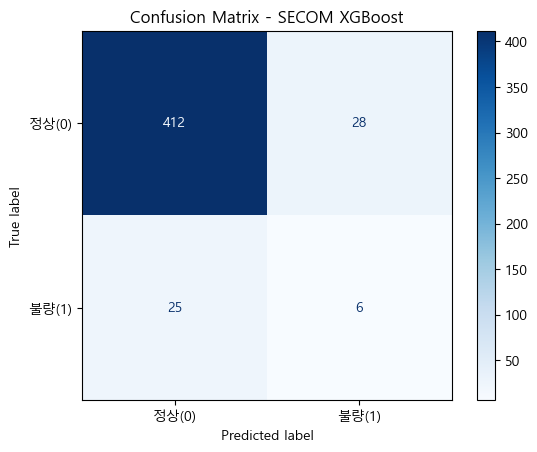

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) 라벨을 0/1로 변환
# SECOM: -1(정상) -> 0, 1(불량) -> 1
y_bin = y['Pass_Fail'].replace({-1: 0, 1: 1})

# 2) 상관계수 상위 20개 센서 선택
top_features = corr_series.head(20).index.tolist()
X_sel = X[top_features]

# 3) train/test 분할 
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# 4) 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5) SMOTE로 불균형 보정
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE 후 라벨 분포:")
print(y_train_res.value_counts())

# 6) XGBoost 학습
model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train_res, y_train_res)

# 7) 평가
y_pred = model.predict(X_test_scaled)

print("===== Classification Report =====")
# 다시 사람이 이해하기 쉽게 0->정상, 1->불량이라고 생각하면 됨
print(classification_report(y_test, y_pred, digits=3,
                            target_names=['정상(0)', '불량(1)']))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['정상(0)', '불량(1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SECOM XGBoost")
plt.show()


선택된 센서 수: 39개
['Sensor_60', 'Sensor_104', 'Sensor_511', 'Sensor_349', 'Sensor_432', 'Sensor_435', 'Sensor_431', 'Sensor_436', 'Sensor_22', 'Sensor_29']
SMOTE 후 라벨 분포:
Pass_Fail
0    1023
1    1023
Name: count, dtype: int64


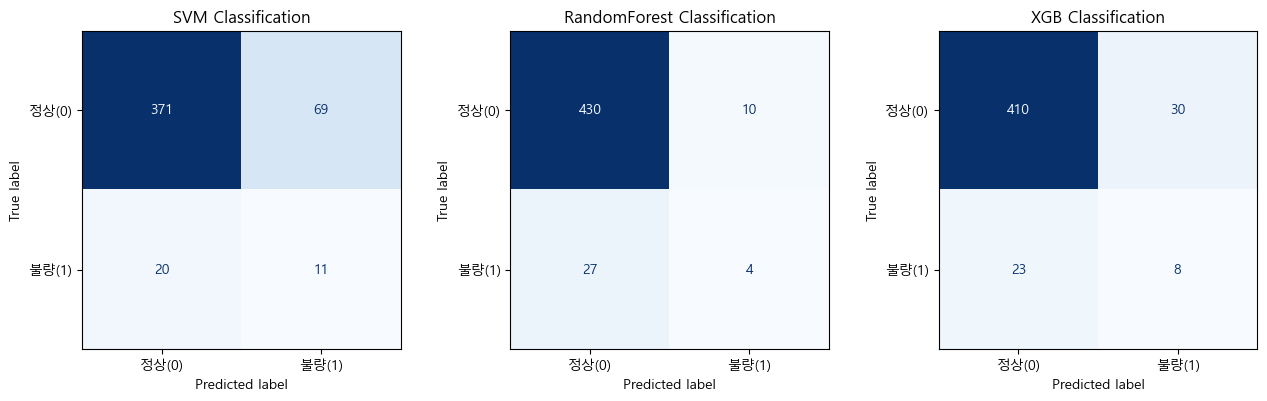


===== 모델별 성능 요약 =====


,정확도,불량재현율(Recall_1),불량정밀도(Precision_1),불량F1
SVM,0.811,0.355,0.138,0.198
RandomForest,0.921,0.129,0.286,0.178
XGB,0.887,0.258,0.211,0.232


In [10]:
# =======================
# 라벨을 0/1로 변환
# =======================
y_bin = y['Pass_Fail'].replace({-1: 0, 1: 1})

# =======================
# ③ Feature Selection
selected_features = corr_series[corr_series >= 0.069].index.tolist()
print(f"선택된 센서 수: {len(selected_features)}개")
print(selected_features[:10])

# 선택된 피처만 가져오고 결측 대체 한번더
X_sel = X[selected_features].copy()
X_sel = X_sel.fillna(X_sel.mean())  

# =======================
# 데이터 분할 (Train/Test)
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# =======================
# ④ 정규화 (Normalization)
# =======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =======================
# SMOTE (불균형 데이터 처리)
# =======================
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE 후 라벨 분포:")
print(y_train_res.value_counts())

# =======================
# ⑤ 모델링: SVM / RandomForest / XGB
# =======================
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGB": XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {"cm": cm, "report": report}

# =======================
# 결과 비교 시각화
# =======================
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, (name, result) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=result["cm"],
        display_labels=["정상(0)", "불량(1)"]
    )
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name} Classification")

plt.tight_layout()
plt.show()

# =======================
# 성능 요약 테이블
# =======================
summary = pd.DataFrame({
    name: {
        "정확도": r["report"]["accuracy"],
        "불량재현율(Recall_1)": r["report"]["1"]["recall"],
        "불량정밀도(Precision_1)": r["report"]["1"]["precision"],
        "불량F1": r["report"]["1"]["f1-score"]
    } for name, r in results.items()
}).T

print("\n===== 모델별 성능 요약 =====")
display(summary.style.format("{:.3f}"))


In [11]:
#SVM 불량예측률 높음, false Alarm 많음
#랜덤포레스트 불량예측률 낮음, False Alarm 적음
#XGB Precision/Recall 균형 좋음

C:\Users\EL11\AppData\Local\Temp\ipykernel_3400\1345326134.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Sensor', palette='viridis')


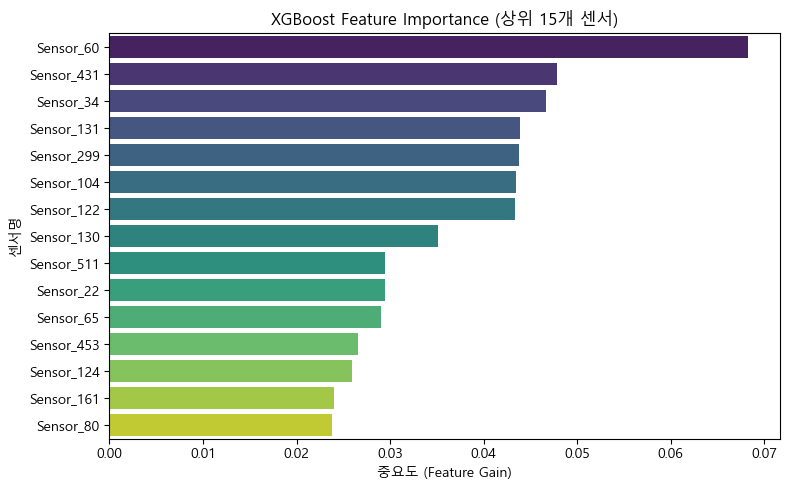

,Sensor,Importance
0,Sensor_60,0.068287
6,Sensor_431,0.047807
27,Sensor_34,0.046694
33,Sensor_131,0.043938
13,Sensor_299,0.043778
1,Sensor_104,0.043461
21,Sensor_122,0.043314
11,Sensor_130,0.035125
2,Sensor_511,0.029495
8,Sensor_22,0.029465


In [12]:
# =======================
# XGBoost Feature Importance
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# XGB 모델에서 feature importance 추출
feature_importance = model = results["XGB"]
xgb_model = models["XGB"]
xgb_model.fit(X_train_res, y_train_res)

# 중요도 추출
importances = xgb_model.feature_importances_
feature_names = X_sel.columns

importance_df = pd.DataFrame({
    'Sensor': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 상위 15개 센서만 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df.head(15), x='Importance', y='Sensor', palette='viridis')
plt.title("XGBoost Feature Importance (상위 15개 센서)")
plt.xlabel("중요도 (Feature Gain)")
plt.ylabel("센서명")
plt.tight_layout()
plt.show()

# 전체 중요도 테이블 보기
importance_df.head(20)


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 1) 테스트셋에서 불량일 확률 가져오기
proba = xgb_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1(불량)의 확률

thresholds = np.arange(0.2, 0.61, 0.05)  # 0.20 ~ 0.60까지 0.05 간격
rows = []

for th in thresholds:
    y_pred_th = (proba >= th).astype(int)
    prec = precision_score(y_test, y_pred_th, zero_division=0)
    rec = recall_score(y_test, y_pred_th, zero_division=0)
    f1 = f1_score(y_test, y_pred_th, zero_division=0)
    cm = confusion_matrix(y_test, y_pred_th, labels=[0,1])
    rows.append({
        "threshold": th,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "TN": cm[0,0],
        "FP": cm[0,1],
        "FN": cm[1,0],
        "TP": cm[1,1],
    })

th_df = pd.DataFrame(rows)
th_df


,threshold,precision_1,recall_1,f1_1,TN,FP,FN,TP
0,0.20,0.180328,0.709677,0.287582,340,100,9,22
1,0.25,0.210000,0.677419,0.320611,361,79,10,21
2,0.30,0.216867,0.580645,0.315789,375,65,13,18
3,0.35,0.202703,0.483871,0.285714,381,59,16,15
4,0.40,0.200000,0.387097,0.263736,392,48,19,12
5,0.45,0.200000,0.322581,0.246914,400,40,21,10
6,0.50,0.210526,0.258065,0.231884,410,30,23,8
7,0.55,0.218750,0.225806,0.222222,415,25,24,7
8,0.60,0.250000,0.193548,0.218182,422,18,25,6


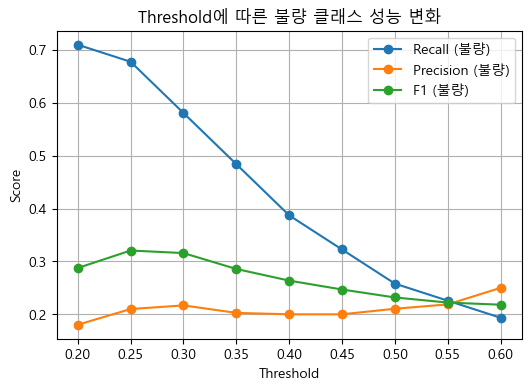

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(th_df["threshold"], th_df["recall_1"], label="Recall (불량)", marker="o")
plt.plot(th_df["threshold"], th_df["precision_1"], label="Precision (불량)", marker="o")
plt.plot(th_df["threshold"], th_df["f1_1"], label="F1 (불량)", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold에 따른 불량 클래스 성능 변화")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import pandas as pd
import numpy as np

# X: 전처리 끝난 전체 데이터, y_bin: 0/1 라벨
normal_data = X_sel[y_bin == 0]   # 정상(0)만

stats = []
for col in normal_data.columns:
    mu = normal_data[col].mean()
    sigma = normal_data[col].std()
    p25 = normal_data[col].quantile(0.25)
    p75 = normal_data[col].quantile(0.75)
    stats.append({
        "sensor": col,
        "mean": mu,
        "std": sigma,
        "p25": p25,
        "p75": p75
    })

stats_df = pd.DataFrame(stats)
stats_df.to_csv("sensor_normal_range.csv", index=False)


In [16]:
topN = importance_df.head(20)
topN[['Sensor', 'Importance']].to_json("top_features.json", orient="records")


In [17]:
def is_out_of_range(sensor_name: str, sensor_value: float, stats_dict: dict, z_thresh: float = 2.5) -> bool:
    info = stats_dict.get(sensor_name)
    if info is None:
        return False  # 모르는 센서면 일단 패스
    mean = info["mean"]
    std = info["std"]
    if std == 0 or std is None:
        return False  # 분산이 없으면 이상 판정 어려우니 통과
    z = (sensor_value - mean) / std
    return abs(z) > z_thresh


In [18]:
import csv

stats_dict = {}
with open("sensor_normal_range.csv", newline="", encoding="utf-8") as f:
    for row in csv.DictReader(f):
        stats_dict[row["sensor"]] = {
            "mean": float(row["mean"]),
            "std": float(row["std"]),
            "p25": float(row["p25"]),
            "p75": float(row["p75"]),
        }


In [19]:
def detect_root_causes(payload: dict, top_features: list, stats_dict: dict):
    sensors = payload["sensors"]
    root_causes = []

    for item in top_features:   # 예: [{"Sensor": "Sensor_60", "Importance": 0.07}, ...]
        name = item["Sensor"] if isinstance(item, dict) else item
        val = sensors.get(name)
        if val is None:
            continue
        if is_out_of_range(name, val, stats_dict):
            root_causes.append({
                "sensor": name,
                "value": val,
                "severity": "high",   # 나중에 z-score 크기로 gradation 가능
            })

    return root_causes


In [20]:
#함수테스트

import pandas as pd

stats_df = pd.read_csv("sensor_normal_range.csv")
print(stats_df.head())
print(len(stats_df))  # 센서 몇 개 들어갔는지


       sensor       mean        std       p25       p75
0   Sensor_60   2.565363   9.290839  -1.96275   3.89045
1  Sensor_104  -0.009912   0.002993  -0.01190  -0.00840
2  Sensor_511  54.442400  35.745369  35.16915  63.03625
3  Sensor_349   0.024297   0.010261   0.01805   0.02700
4  Sensor_432  21.192018  31.824908  10.92480  21.62315
39


In [21]:
stats_dict = {
    row["sensor"]: {
        "mean": row["mean"],
        "std": row["std"],
        "p25": row["p25"],
        "p75": row["p75"],
    }
    for _, row in stats_df.iterrows()
}

print("Sensor_60 in dict? ->", "Sensor_60" in stats_dict)
print(stats_dict.get("Sensor_60"))

Sensor_60 in dict? -> True
{'mean': 2.5653626728096466, 'std': 9.29083906895383, 'p25': -1.96275, 'p75': 3.89045}


In [22]:
#잘찍히는지 확인
def is_out_of_range(sensor_name: str, sensor_value: float, stats_dict: dict, z_thresh: float = 2.5) -> bool:
    info = stats_dict.get(sensor_name)
    if info is None:
        return False
    mean = info["mean"]
    std = info["std"]
    if std == 0 or pd.isna(std):
        return False
    z = (sensor_value - mean) / std
    return abs(z) > z_thresh

# 예: 정상값 근처
print("정상값 테스트:", is_out_of_range("Sensor_60", stats_dict["Sensor_60"]["mean"], stats_dict))
# 예: 일부러 크게 벗어나게
print("이상값 테스트:", is_out_of_range("Sensor_60", stats_dict["Sensor_60"]["mean"] + 5*stats_dict["Sensor_60"]["std"], stats_dict))


정상값 테스트: False
이상값 테스트: True


In [23]:
#실시간 처럼 테스트
import json

# 중요 센서 리스트
top_features = ["Sensor_60", "Sensor_431", "Sensor_34"]

def detect_root_causes(payload: dict, top_features: list, stats_dict: dict):
    sensors = payload["sensors"]
    root_causes = []
    for name in top_features:
        val = sensors.get(name)
        if val is None:
            continue
        if is_out_of_range(name, val, stats_dict):
            root_causes.append({
                "sensor": name,
                "value": val,
            })
    return root_causes

# 테스트용 payload (일부러 Sensor_60만 비정상으로)
test_payload = {
    "timestamp": "2025-11-11T14:05:00Z",
    "lot_id": "LOT-TEST-001",
    "equipment_id": "EQP-01",
    "sensors": {
        "Sensor_60": stats_dict["Sensor_60"]["mean"] + 4*stats_dict["Sensor_60"]["std"],
        "Sensor_431": stats_dict["Sensor_431"]["mean"],
        "Sensor_34": stats_dict["Sensor_34"]["mean"]
    }
}

root_causes = detect_root_causes(test_payload, top_features, stats_dict)
print(root_causes)


[{'sensor': 'Sensor_60', 'value': 39.728718948624966}]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 실험할 피처 수 / 임계값
feature_sizes = [30, 39, 50] #30-좀더줄인거, 39-원래, 50-좀더늘린거
thresholds = [0.25, 0.30, 0.35]

results = []

for k in feature_sizes:
    # 1) 상위 k개 피처 선택
    topk_features = corr_series.head(k).index.tolist()
    X_k = X[topk_features].copy().fillna(X[topk_features].mean())

    # 2) train / test
    X_train, X_test, y_train, y_test = train_test_split(
        X_k, y_bin, test_size=0.3, random_state=42, stratify=y_bin
    )

    # 3) 스케일링
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # 4) SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_s, y_train)

    # 5) 모델 학습 (고정 파라미터)
    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train_res, y_train_res)

    # 6) 테스트 확률
    proba = model.predict_proba(X_test_s)[:, 1]

    # 7) 임계값별 성능
    for th in thresholds:
        y_pred = (proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()

        # 지표 계산
        acc = (tp + tn) / (tp + tn + fp + fn)
        recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
        far = fp / (fp + tn) if (fp + tn) > 0 else 0   # 오경보율

        results.append({
            "features": k,
            "threshold": th,
            "accuracy": acc,
            "recall_1": recall_1,
            "precision_1": precision_1,
            "f1_1": f1_1,
            "false_alarm_rate": far,
            "tp": tp,
            "fp": fp,
            "tn": tn,
            "fn": fn,
        })

# 표로 보기
df_res = pd.DataFrame(results).sort_values(["features", "threshold"])
df_res


,features,threshold,accuracy,recall_1,precision_1,f1_1,false_alarm_rate,tp,fp,tn,fn
0,30,0.25,0.789809,0.580645,0.173077,0.266667,0.195455,18,86,354,13
1,30,0.30,0.813163,0.516129,0.179775,0.266667,0.165909,16,73,367,15
2,30,0.35,0.840764,0.516129,0.210526,0.299065,0.136364,16,60,380,15
3,39,0.25,0.811040,0.677419,0.210000,0.320611,0.179545,21,79,361,10
4,39,0.30,0.834395,0.580645,0.216867,0.315789,0.147727,18,65,375,13
5,39,0.35,0.840764,0.483871,0.202703,0.285714,0.134091,15,59,381,16
6,50,0.25,0.828025,0.548387,0.202381,0.295652,0.152273,17,67,373,14
7,50,0.30,0.859873,0.516129,0.238806,0.326531,0.115909,16,51,389,15
8,50,0.35,0.876858,0.419355,0.245283,0.309524,0.090909,13,40,400,18


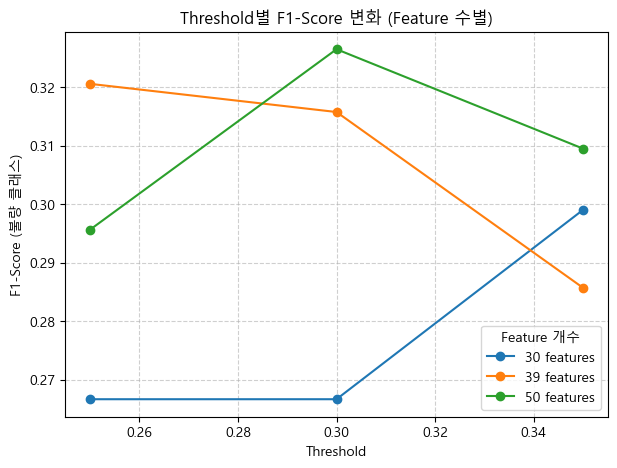

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for k in df_res['features'].unique():
    subset = df_res[df_res['features'] == k]
    plt.plot(subset['threshold'], subset['f1_1'],
             marker='o', label=f'{k} features')

plt.title('Threshold별 F1-Score 변화 (Feature 수별)')
plt.xlabel('Threshold')
plt.ylabel('F1-Score (불량 클래스)')
plt.legend(title='Feature 개수')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


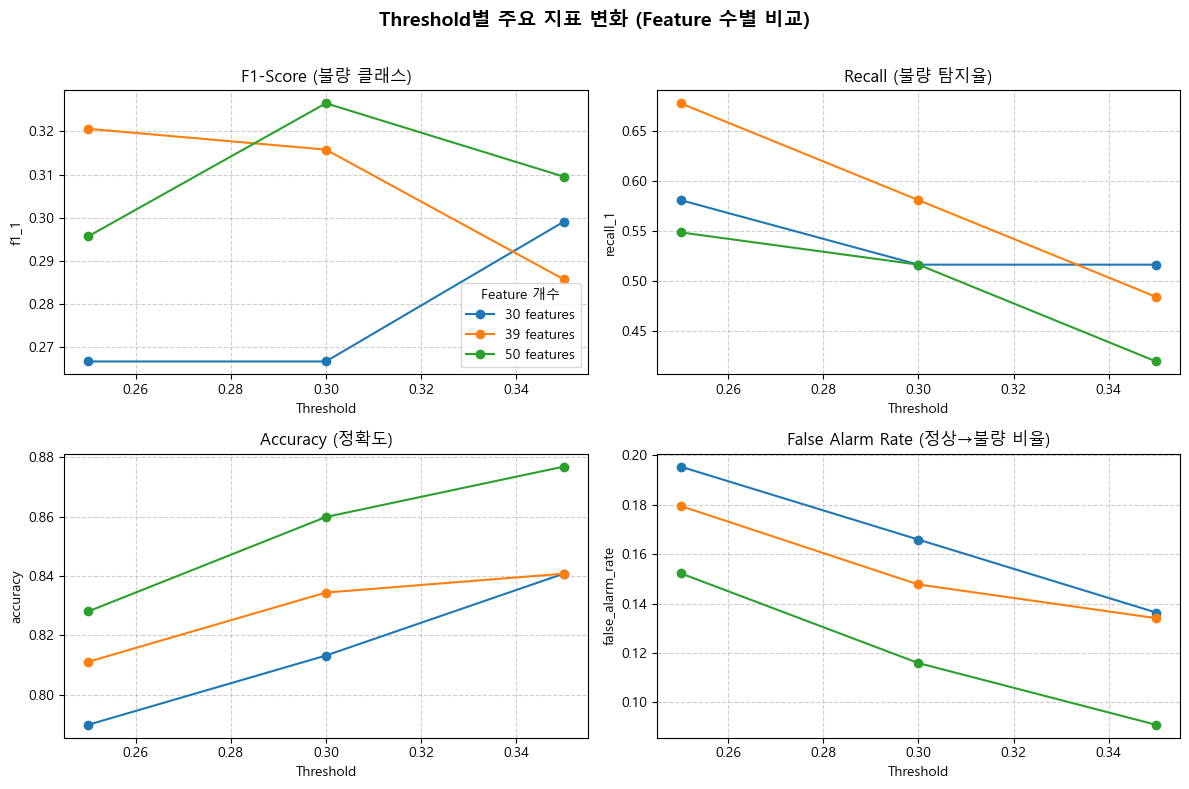

In [26]:
import matplotlib.pyplot as plt

metrics = ["f1_1", "recall_1", "accuracy", "false_alarm_rate"]
titles = [
    "F1-Score (불량 클래스)",
    "Recall (불량 탐지율)",
    "Accuracy (정확도)",
    "False Alarm Rate (정상→불량 비율)"
]

plt.figure(figsize=(12, 8))

for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(2, 2, i)
    for k in df_res['features'].unique():
        subset = df_res[df_res['features'] == k]
        plt.plot(subset['threshold'], subset[metric], marker='o', label=f'{k} features')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)
    if i == 1:
        plt.legend(title='Feature 개수')

plt.suptitle('Threshold별 주요 지표 변화 (Feature 수별 비교)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

RANDOM_STATE = 42
THRESH = 0.30
BASE_K = 39            # 상관계수 컷으로 쓰던 기본 피처 수
TOP_K_FOR_FE = 10      # 상호작용/비율을 만들 상위 중요 피처 개수

# ----------------------------
# 1) 피처 선택 (상관계수 상위)
# ----------------------------
selected = corr_series.head(BASE_K).index.tolist()
X_base = X[selected].copy()

# ----------------------------
# 2) 간단 FE 함수
#    - signed_log: log1p(|x|)*sign(x) (음수 안전)
#    - square: x^2 (비선형)
#    - interactions: 상위 TOP_K_FOR_FE 피처 간 (x_i * x_j)
#    - ratios: x_i / (x_j + eps)
# ----------------------------
def build_features(df, top_cols):
    df_fe = df.copy()
    eps = 1e-6

    # (a) signed-log, (b) square
    for c in df.columns:
        df_fe[f"{c}_slog"] = np.sign(df[c]) * np.log1p(np.abs(df[c]))
        df_fe[f"{c}_sq"]   = df[c] ** 2

    # (c) interactions & (d) ratios (상위 중요 피처에 한정해서 폭발 방지)
    # 중요 피처는 XGBoost 한 번 학습해서 뽑거나, corr 상위에서 뽑아도 됨
    # 여기서는 corr 상위 중 TOP_K_FOR_FE로 제한
    cols = list(top_cols)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            df_fe[f"{a}*{b}"] = df[a] * df[b]
            df_fe[f"{a}/{b}"] = df[a] / (df[b].abs() + eps)

    return df_fe

# ----------------------------
# 3) 학습/평가 공통 함수
# ----------------------------
def train_eval_with_xgb(X_df, y, thresh=THRESH):
    # 결측 평균 대체
    X_imp = X_df.fillna(X_df.mean())
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_imp, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )
    # 스케일
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    # SMOTE
    sm = SMOTE(random_state=RANDOM_STATE)
    X_res, y_res = sm.fit_resample(X_tr_s, y_tr)
    # XGB
    model = XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
    model.fit(X_res, y_res)
    proba = model.predict_proba(X_te_s)[:, 1]
    y_pred = (proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()

    acc = (tp+tn)/(tp+tn+fp+fn)
    rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    far = fp/(fp+tn) if (fp+tn)>0 else 0.0
    return {
        "accuracy":acc, "recall_1":rec, "precision_1":prec, "f1_1":f1, "FAR":far,
        "tp":tp,"fp":fp,"tn":tn,"fn":fn
    }

# ----------------------------
# 4) 베이스라인 vs FE 비교
# ----------------------------
# FE용 top 컬럼(상관 상위에서 TOP_K_FOR_FE만)
top_cols_for_fe = corr_series.head(TOP_K_FOR_FE).index.tolist()

X_fe = build_features(X_base, top_cols_for_fe)

res_base = train_eval_with_xgb(X_base, y_bin)
res_fe   = train_eval_with_xgb(X_fe,   y_bin)

summary = pd.DataFrame([res_base, res_fe], index=["Baseline(39)", "FE(39 + 로그/제곱/상호작용/비율)"])
print(summary.round(4))


C:\Users\EL11\AppData\Local\Temp\ipykernel_3400\2872605890.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe[f"{a}/{b}"] = df[a] / (df[b].abs() + eps)
C:\Users\EL11\AppData\Local\Temp\ipykernel_3400\2872605890.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe[f"{a}*{b}"] = df[a] * df[b]
C:\Users\EL11\AppData\Local\Temp\ipykernel_3400\2872605890.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

                        accuracy  recall_1  precision_1    f1_1     FAR  tp  \
Baseline(39)              0.8344    0.5806       0.2169  0.3158  0.1477  18   
FE(39 + 로그/제곱/상호작용/비율)    0.8535    0.4516       0.2121  0.2887  0.1182  14   

                        fp   tn  fn  
Baseline(39)            65  375  13  
FE(39 + 로그/제곱/상호작용/비율)  52  388  17  


In [ ]:
#정확도(Accuracy) ↑ → 모델이 “정상” 구분을 더 잘하게 됨.
#오경보율(FAR) ↓ → False Alarm이 줄었음 (운영 안정성 개선).
#하지만 Recall ↓ → 불량 탐지는 덜 민감하게 됨 (탐지력 약화).
#Precision 거의 동일 → 불량으로 판단할 땐 여전히 20% 정도 맞음.

In [28]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
import pandas as pd

def run_sampling_experiment(X_df, y, sampler, sampler_name, threshold=0.30):
    X_imp = X_df.fillna(X_df.mean())
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_imp, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # 샘플링 (SMOTE or ADASYN)
    X_res, y_res = sampler.fit_resample(X_tr_s, y_tr)

    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_res, y_res)

    proba = model.predict_proba(X_te_s)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()

    acc = (tp+tn)/(tp+tn+fp+fn)
    rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    far = fp/(fp+tn) if (fp+tn)>0 else 0.0

    print(f"\n===== {sampler_name} 결과 =====")
    print(f"Accuracy: {acc:.4f} | Recall(1): {rec:.4f} | Precision(1): {prec:.4f} | F1: {f1:.4f} | FAR: {far:.4f}")
    print(f"Confusion Matrix -> TP:{tp}, FP:{fp}, TN:{tn}, FN:{fn}")
    return {"샘플링": sampler_name, "accuracy": acc, "recall_1": rec,
            "precision_1": prec, "f1_1": f1, "FAR": far}

# ==============================
# 실행
# ==============================
res_smote  = run_sampling_experiment(X_base, y_bin, SMOTE(random_state=42), "SMOTE")
res_adasyn = run_sampling_experiment(X_base, y_bin, ADASYN(random_state=42), "ADASYN")

pd.DataFrame([res_smote, res_adasyn])



===== SMOTE 결과 =====
Accuracy: 0.8344 | Recall(1): 0.5806 | Precision(1): 0.2169 | F1: 0.3158 | FAR: 0.1477
Confusion Matrix -> TP:18, FP:65, TN:375, FN:13

===== ADASYN 결과 =====
Accuracy: 0.8195 | Recall(1): 0.5161 | Precision(1): 0.1860 | F1: 0.2735 | FAR: 0.1591
Confusion Matrix -> TP:16, FP:70, TN:370, FN:15


,샘플링,accuracy,recall_1,precision_1,f1_1,FAR
0,SMOTE,0.834395,0.580645,0.216867,0.315789,0.147727
1,ADASYN,0.819533,0.516129,0.186047,0.273504,0.159091


In [ ]:
#SMOTE가 전체적으로 정확도·F1·안정성 모두 우세.

In [29]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def xgb_weight_experiment(X_df, y, weight_list=[1,2,3,5,7], threshold=0.30):
    X_imp = X_df.fillna(X_df.mean())
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_imp, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # SMOTE 유지
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_tr_s, y_tr)

    results = []

    for w in weight_list:
        model = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=w,          # 주요코드
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)

        proba = model.predict_proba(X_te_s)[:, 1]
        y_pred = (proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()

        acc = (tp+tn)/(tp+tn+fp+fn)
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
        far = fp/(fp+tn) if (fp+tn)>0 else 0.0

        results.append({
            "scale_pos_weight": w,
            "accuracy": acc, "recall_1": rec, "precision_1": prec,
            "f1_1": f1, "FAR": far,
            "tp": tp, "fp": fp, "tn": tn, "fn": fn
        })

    return pd.DataFrame(results)

# ==============================
# 실행
# ==============================
res_weight = xgb_weight_experiment(X_base, y_bin)
res_weight.round(4)


,scale_pos_weight,accuracy,recall_1,precision_1,f1_1,FAR,tp,fp,tn,fn
0,1,0.8344,0.5806,0.2169,0.3158,0.1477,18,65,375,13
1,2,0.7962,0.6774,0.1963,0.3043,0.1955,21,86,354,10
2,3,0.7877,0.6774,0.1892,0.2958,0.2045,21,90,350,10
3,5,0.7643,0.6774,0.1721,0.2745,0.2295,21,101,339,10
4,7,0.7495,0.7097,0.1679,0.2716,0.2477,22,109,331,9


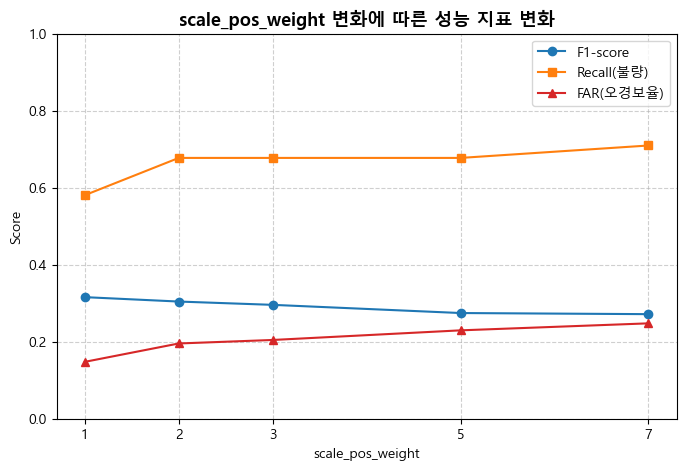

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(res_weight["scale_pos_weight"], res_weight["f1_1"], marker="o", label="F1-score", color="tab:blue")
plt.plot(res_weight["scale_pos_weight"], res_weight["recall_1"], marker="s", label="Recall(불량)", color="tab:orange")
plt.plot(res_weight["scale_pos_weight"], res_weight["FAR"], marker="^", label="FAR(오경보율)", color="tab:red")

plt.title("scale_pos_weight 변화에 따른 성능 지표 변화", fontsize=13, fontweight="bold")
plt.xlabel("scale_pos_weight")
plt.ylabel("Score")
plt.xticks(res_weight["scale_pos_weight"])
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [31]:

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 기본 데이터 준비 (SMOTE 이후로 맞춰둔 상태)
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)
X_res, y_res = SMOTE(random_state=42).fit_resample(X_tr_s, y_tr)

# 파라미터 탐색 범위
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [2]  # 이전 실험에서 최적값 유지
}

# 모델 + GridSearch
xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_res, y_res)

print("최적 하이퍼파라미터:")
print(grid.best_params_)
print(f"최고 F1-score: {grid.best_score_:.4f}")



Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\EL11\projects-semicon\azure-semicon\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


최적 하이퍼파라미터:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.8}
최고 F1-score: 0.9606


In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# 0) 데이터: X_sel, y_bin (이미 선정된 39/50 피처 등)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# 1) 파이프라인 (fit에서만 SMOTE 적용, predict 시엔 자동 무시)
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(eval_metric="logloss", random_state=42))
])

# 2) 그리드 (xgb__ 로 접두사 )
param_grid = {
    "xgb__max_depth": [4, 5],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__n_estimators": [200, 300],
    "xgb__subsample": [0.8],
    "xgb__colsample_bytree": [0.6, 0.8],
    "xgb__scale_pos_weight": [2]   # 이전 실험 최적
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",     # 불량 클래스 F1 기준
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 3) 학습(누수 없는 CV) + 베스트 파라미터
grid.fit(X_tr, y_tr)
print("Best params:", grid.best_params_)
print("CV best F1:", grid.best_score_)

# 4) 홀드아웃 테스트 평가 (threshold 그리드로 최적점 선택)
proba = grid.predict_proba(X_te)[:, 1]
ths = np.round(np.arange(0.25, 0.36, 0.05), 2)  # 0.25, 0.30, 0.35
rows = []
for th in ths:
    y_pred = (proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    rec = tp/(tp+fn) if (tp+fn) else 0
    prec = tp/(tp+fp) if (tp+fp) else 0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0
    far = fp/(fp+tn) if (fp+tn) else 0
    rows.append({"threshold": th, "accuracy": acc, "recall_1": rec,
                 "precision_1": prec, "f1_1": f1, "FAR": far,
                 "tp": tp, "fp": fp, "tn": tn, "fn": fn})
res = pd.DataFrame(rows).sort_values("f1_1", ascending=False)
print(res.round(4).to_string(index=False))

# 5) 최적 threshold로 리포트 출력
best_th = res.iloc[0]["threshold"]
y_hat = (proba >= best_th).astype(int)
print(f"\nTest @ threshold={best_th:.2f}")
print(confusion_matrix(y_te, y_hat, labels=[0,1]))
print(classification_report(y_te, y_hat, digits=3))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 2, 'xgb__subsample': 0.8}
CV best F1: 0.19766815157014794
 threshold  accuracy  recall_1  precision_1   f1_1    FAR  tp  fp  tn  fn
      0.35    0.8769    0.3548       0.2245 0.2750 0.0864  11  38 402  20
      0.25    0.8535    0.4194       0.2031 0.2737 0.1159  13  51 389  18
      0.30    0.8641    0.3548       0.2000 0.2558 0.1000  11  44 396  20

Test @ threshold=0.35
[[402  38]
 [ 20  11]]
              precision    recall  f1-score   support

           0      0.953     0.914     0.933       440
           1      0.224     0.355     0.275        31

    accuracy                          0.877       471
   macro avg      0.589     0.634     0.604       471
weighted avg      0.905     0.877     0.889       471



In [35]:
#임계값 최적화
import numpy as np
from sklearn.metrics import confusion_matrix

c_fp, c_fn = 5.0, 1.0   # ← 오탐 비용을 더 크게
ths = np.round(np.arange(0.15, 0.51, 0.01), 2)
rows=[]
proba = grid.predict_proba(X_te)[:,1]  # 방금 만든 best 파이프라인 기준
for th in ths:
    y_hat = (proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_hat, labels=[0,1]).ravel()
    cost = c_fp*fp + c_fn*fn
    rows.append((th, cost, fp/(fp+tn), tp/(tp+fn)))
best = min(rows, key=lambda x: x[1])
print(f"Best th by cost: {best[0]} | Cost:{best[1]:.1f} | FAR:{best[2]:.3f} | Recall:{best[3]:.3f}")


Best th by cost: 0.49 | Cost:140.0 | FAR:0.052 | Recall:0.194


In [36]:
#확률보정
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

pipe_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(**{  # best params
        'colsample_bytree':0.6,'learning_rate':0.1,'max_depth':5,
        'n_estimators':200,'scale_pos_weight':2,'subsample':0.8,
        'eval_metric':'logloss', 'random_state':42
    }))
])

pipe_raw.fit(X_tr, y_tr)
cal = CalibratedClassifierCV(pipe_raw, method="isotonic", cv=3)  # Platt('sigmoid')도 가능
cal.fit(X_tr, y_tr)
proba_cal = cal.predict_proba(X_te)[:,1]
# 기존 임계값 0.35 vs 보정후 0.35 비교
for name, p in [("raw", pipe_raw.predict_proba(X_te)[:,1]), ("iso", proba_cal)]:
    y_hat = (p>=0.35).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_hat, labels=[0,1]).ravel()
    far = fp/(fp+tn); rec = tp/(tp+fn)
    print(name, "FAR:", round(far,3), "Recall:", round(rec,3))


raw FAR: 0.086 Recall: 0.355
iso FAR: 0.007 Recall: 0.0


In [39]:
#2단계 필터링, 오탐률 감소
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

# 1) 정상(0)로만 IF 학습
X_tr_s = StandardScaler().fit_transform(X_tr.fillna(X_tr.mean()))
iso = IsolationForest(random_state=42, contamination=0.05)  # 컷 강도 조절
iso.fit(X_tr_s[y_tr==0])

# 2) 테스트 분류
X_te_imp = X_te.fillna(X_te.mean())
X_te_s   = StandardScaler().fit_transform(X_tr.fillna(X_tr.mean())).dot(0)  # 스케일러 재사용 주의
scaler = StandardScaler().fit(X_tr.fillna(X_tr.mean()))
X_te_s = scaler.transform(X_te_imp)

mask_pass = (iso.predict(X_te_s) == 1)   # 명백히 정상
proba = grid.predict_proba(X_te)[:,1]

y_hat = np.zeros_like(y_te)
y_hat[~mask_pass] = (proba[~mask_pass] >= 0.35).astype(int)  # “불확실/이상 후보”만 XGB로 판정
tn, fp, fn, tp = confusion_matrix(y_te, y_hat, labels=[0,1]).ravel()
far = fp/(fp+tn); rec = tp/(tp+fn)
print("Two-stage FAR:", round(far,3), "| Recall:", round(rec,3), "| TN FP FN TP:", tn, fp, fn, tp)


Two-stage FAR: 0.005 | Recall: 0.065 | TN FP FN TP: 438 2 29 2


In [40]:
xgb_params = {  
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200,
    'scale_pos_weight': 2,
    'subsample': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}

xgb = XGBClassifier(**xgb_params).fit(X_res, y_res)
rf  = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_res, y_res)
svm = SVC(C=1, gamma='scale', probability=True, random_state=42).fit(X_res, y_res)

p_xgb = xgb.predict_proba(X_te_s)[:,1]
p_rf  = rf.predict_proba(X_te_s)[:,1]
p_svm = svm.predict_proba(X_te_s)[:,1]
p_avg = (p_xgb + p_rf + p_svm)/3

for th in [0.30, 0.35, 0.40]:
    y_hat = (p_avg>=th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_hat, labels=[0,1]).ravel()
    far = fp/(fp+tn)
    rec = tp/(tp+fn)
    print(f"avg@{th} → FAR={far:.3f}, Recall={rec:.3f}, TP:{tp}, FP:{fp}, TN:{tn}, FN:{fn}")


avg@0.3 → FAR=0.139, Recall=0.419, TP:13, FP:61, TN:379, FN:18
avg@0.35 → FAR=0.123, Recall=0.387, TP:12, FP:54, TN:386, FN:19
avg@0.4 → FAR=0.098, Recall=0.355, TP:11, FP:43, TN:397, FN:20


In [ ]:
#단일 XGB(th=0.35: FAR 0.086 / Recall 0.355)보다 오경보가 더 큼, 리콜은 동일 → 이득 없음

In [42]:
#XGB + RF + SVM 각각 파이프라인 학습 → 2/3 다수결 비교
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
TH = 0.35  # 운영 기준 threshold

# 1) 데이터 분할 (기존과 동일하게)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=RANDOM_STATE, stratify=y_bin
)

# 2) 각 모델 파이프라인 정의 (Scaler → SMOTE → Model)
xgb_params = {
    'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5,
    'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.8,
    'eval_metric': 'logloss', 'random_state': RANDOM_STATE
}

pipe_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", XGBClassifier(**xgb_params))
])

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
])

pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", SVC(C=1, gamma="scale", probability=True, random_state=RANDOM_STATE))
])

# 3) 학습
pipe_xgb.fit(X_tr, y_tr)
pipe_rf.fit(X_tr, y_tr)
pipe_svm.fit(X_tr, y_tr)

# 4) 확률 예측
p_xgb = pipe_xgb.predict_proba(X_te)[:, 1]
p_rf  = pipe_rf.predict_proba(X_te)[:, 1]
p_svm = pipe_svm.predict_proba(X_te)[:, 1]

# 5) 단일 XGB 기준 (비교용)
y_xgb = (p_xgb >= TH).astype(int)

# 6) 보수적 다수결 (2/3 이상 불량이면 불량)
y_rf  = (p_rf  >= TH).astype(int)
y_svm = (p_svm >= TH).astype(int)
y_vote23 = ((y_xgb + y_rf + y_svm) >= 2).astype(int)

# (선택) 더 보수적인 3/3 전원일치
y_vote33 = ((y_xgb + y_rf + y_svm) == 3).astype(int)

def eval_and_print(name, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    rec = tp/(tp+fn) if (tp+fn) else 0
    prec = tp/(tp+fp) if (tp+fp) else 0
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec) else 0
    far = fp/(fp+tn) if (fp+tn) else 0
    print(f"\n[{name}]  Acc:{acc:.3f} | Recall:{rec:.3f} | Precision:{prec:.3f} | F1:{f1:.3f} | FAR:{far:.3f}")
    print(f"TN:{tn} FP:{fp} FN:{fn} TP:{tp}")

# 결과 출력
eval_and_print(f"Single XGB@th={TH}", y_xgb)
eval_and_print(f"Hard Voting 2/3@th={TH}", y_vote23)
eval_and_print(f"Hard Voting 3/3@th={TH}", y_vote33)

# (보너스) 2/3 다수결 threshold 스윕으로 sweet spot 찾기
rows=[]
for th in np.round(np.arange(0.30, 0.46, 0.05),2):
    y23 = ((p_xgb>=th).astype(int) + (p_rf>=th).astype(int) + (p_svm>=th).astype(int) >= 2).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y23, labels=[0,1]).ravel()
    far = fp/(fp+tn); rec = tp/(tp+fn) if (tp+fn) else 0
    rows.append({"th": th, "FAR": far, "Recall": rec, "TP":tp, "FP":fp, "TN":tn, "FN":fn})
print("\n2/3 Voting threshold sweep:")
print(pd.DataFrame(rows).round(3))



[Single XGB@th=0.35]  Acc:0.877 | Recall:0.355 | Precision:0.224 | F1:0.275 | FAR:0.086
TN:402 FP:38 FN:20 TP:11

[Hard Voting 2/3@th=0.35]  Acc:0.879 | Recall:0.419 | Precision:0.250 | F1:0.313 | FAR:0.089
TN:401 FP:39 FN:18 TP:13

[Hard Voting 3/3@th=0.35]  Acc:0.892 | Recall:0.129 | Precision:0.143 | F1:0.136 | FAR:0.055
TN:416 FP:24 FN:27 TP:4

2/3 Voting threshold sweep:
     th    FAR  Recall  TP  FP   TN  FN
0  0.30  0.109   0.484  15  48  392  16
1  0.35  0.089   0.419  13  39  401  18
2  0.40  0.059   0.258   8  26  414  23
3  0.45  0.043   0.226   7  19  421  24


=== Stability metrics (stream) ===
XGB_flip_rate: 0.188
VOTE_flip_rate: 0.174
XGB_prob_std: 0.19300000369548798
VOTE_frac_std: 0.297
XGB_alarm_freq: 0.107
VOTE_alarm_freq: 0.113

XGB  → FAR:0.101  Recall:0.182   (TN:125 FP:14 FN:9 TP:2)
VOTE → FAR:0.094 Recall:0.364  (TN:126 FP:13 FN:7 TP:4)


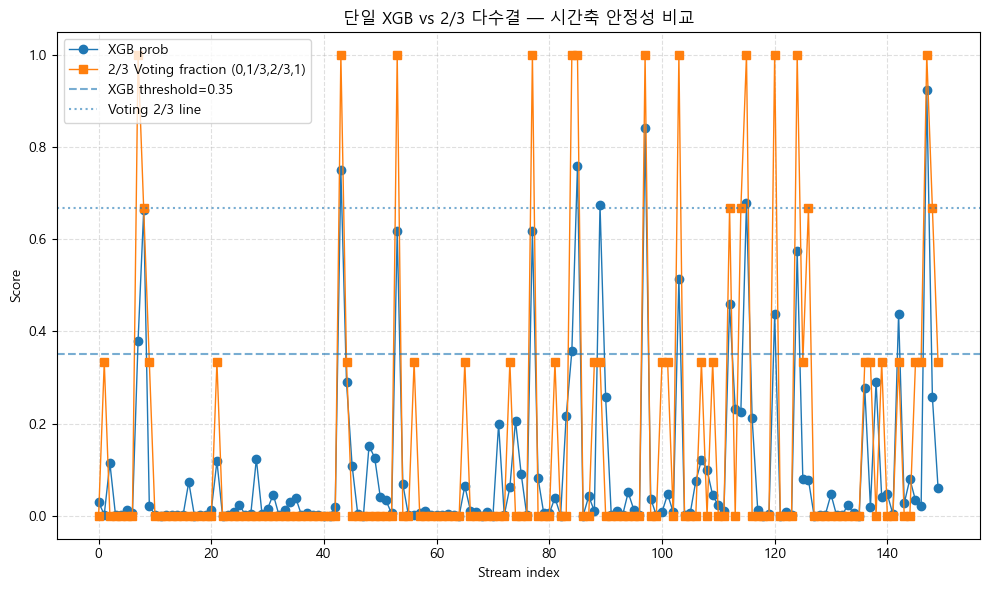

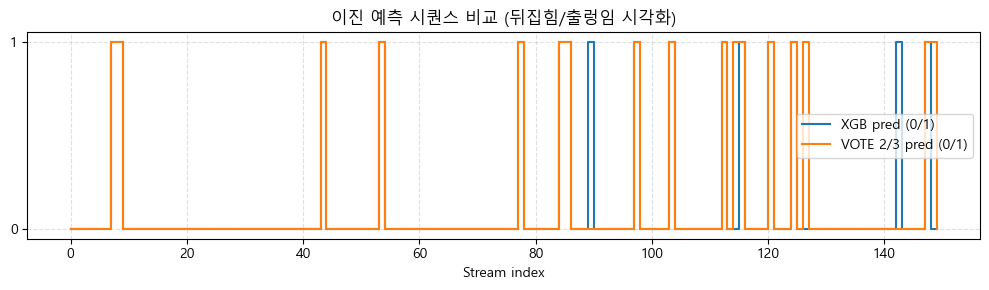

In [43]:
# ============================
# 단일 XGB vs 2/3 다수결: 시간축 안정성 시뮬레이션
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

TH = 0.35           # 운영 기준 threshold
N_STREAM = 150      # 스트림 길이 (원하면 늘려도 OK)

# 1) 스트림 순서 만들기 (테스트셋에서 시계열처럼 흉내)
stream_idx = X_te.sample(n=min(N_STREAM, len(X_te)), random_state=42).index
X_stream = X_te.loc[stream_idx]
y_stream = y_te.loc[stream_idx].reset_index(drop=True)

# 2) 각 모델 확률 & 예측
p_xgb = pipe_xgb.predict_proba(X_stream)[:, 1]
p_rf  = pipe_rf.predict_proba(X_stream)[:, 1]
p_svm = pipe_svm.predict_proba(X_stream)[:, 1]

y_xgb = (p_xgb >= TH).astype(int)
y_rf  = (p_rf  >= TH).astype(int)
y_svm = (p_svm >= TH).astype(int)

# 3) 2/3 다수결 (hard) + "투표비율"(부드러운 지표: 0, 1/3, 2/3, 1)
vote_count = y_xgb + y_rf + y_svm
vote_hard  = (vote_count >= 2).astype(int)
vote_frac  = vote_count / 3.0   # 확률처럼 사용(안정성 비교용)

# 4) 안정성 메트릭
def flip_rate(arr):
    return (arr[1:] != arr[:-1]).mean() if len(arr) > 1 else 0.0

metrics = {
    "XGB_flip_rate":       round(flip_rate(y_xgb), 3),
    "VOTE_flip_rate":      round(flip_rate(vote_hard), 3),
    "XGB_prob_std":        round(np.std(p_xgb), 3),
    "VOTE_frac_std":       round(np.std(vote_frac), 3),
    "XGB_alarm_freq":      round(np.mean(y_xgb), 3),
    "VOTE_alarm_freq":     round(np.mean(vote_hard), 3),
}

# 5) 성능(참값 대비)도 참고로
tn1, fp1, fn1, tp1 = confusion_matrix(y_stream, y_xgb, labels=[0,1]).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y_stream, vote_hard, labels=[0,1]).ravel()
def far_recall(tn, fp, fn, tp):
    FAR = fp/(fp+tn) if (fp+tn)>0 else 0.0
    REC = tp/(tp+fn) if (tp+fn)>0 else 0.0
    return round(FAR,3), round(REC,3)

xgb_FAR, xgb_REC   = far_recall(tn1, fp1, fn1, tp1)
vote_FAR, vote_REC = far_recall(tn2, fp2, fn2, tp2)

print("=== Stability metrics (stream) ===")
for k,v in metrics.items():
    print(f"{k}: {v}")
print(f"\nXGB  → FAR:{xgb_FAR}  Recall:{xgb_REC}   (TN:{tn1} FP:{fp1} FN:{fn1} TP:{tp1})")
print(f"VOTE → FAR:{vote_FAR} Recall:{vote_REC}  (TN:{tn2} FP:{fp2} FN:{fn2} TP:{tp2})")

# 6) 시각화
plt.figure(figsize=(10,6))
plt.plot(p_xgb, label="XGB prob", marker="o", linewidth=1)
plt.plot(vote_frac, label="2/3 Voting fraction (0,1/3,2/3,1)", marker="s", linewidth=1)

# 기준선
plt.axhline(TH, linestyle="--", alpha=0.6, label=f"XGB threshold={TH}")
plt.axhline(2/3, linestyle=":", alpha=0.6, label="Voting 2/3 line")

plt.title("단일 XGB vs 2/3 다수결 — 시간축 안정성 비교")
plt.xlabel("Stream index")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 7) 이진 예측의 '뒤집힘' 비교도 시각화 (선택)
plt.figure(figsize=(10,3))
plt.step(range(len(y_xgb)), y_xgb, where="post", label="XGB pred (0/1)")
plt.step(range(len(vote_hard)), vote_hard, where="post", label="VOTE 2/3 pred (0/1)")
plt.yticks([0,1])
plt.title("이진 예측 시퀀스 비교 (뒤집힘/출렁임 시각화)")
plt.xlabel("Stream index")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
